# ECE 689, Spring 2025
## Homework 1

## Full name:
## NetID:

Please submit the homework as pdf file.

## Imports and Datasets

In [ ]:
# Import some useful packages, please edit as needed

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import copy
import normflows as nf

from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

mps


In [ ]:
# Import some datasets, please plot to make sure it works

from sklearn.datasets import make_circles, make_moons

# ds_KMIST = torchvision.datasets.KMNIST('KMNIST/raw/train-images-idx3-ubyte', train=True, download=True,
#                                        transform=torchvision.transforms.Compose([
#                                            torchvision.transforms.Resize(16),
#                                            torchvision.transforms.ToTensor()]))
ds_USPS  = torchvision.datasets.USPS('USPS', train=True, download=True,
                                     transform=torchvision.transforms.Compose([
                                         torchvision.transforms.Resize(16),
                                         torchvision.transforms.ToTensor()]))


In [ ]:
# Make some datasets, please plot to make sure it works

from sklearn.mixture import GaussianMixture

# some github repos may already have this code,
# do anything fancy e.g. 3 x 3 Gaussians or Gaussians in a circle like a donut

For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

## Question 1: Normalizing Flows

- Select a coupling Normalizing Flow and an autoregressive Normalizing Flow (NF).
- Apply the NF models to MNIST dataset.
- You can resize the MNIST images to 7 × 7 pixels to reduce computational complexity.

Some github repositories:
- https://github.com/zhongyuchen/generative-models
- https://github.com/kamenbliznashki/normalizing_flows
- https://github.com/karpathy/pytorch-normalizing-flows
- https://github.com/VincentStimper/normalizing-flows
- remember to list these references below if you use them!
- if you find some other references, do share too!

For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(8),
    torchvision.transforms.ToTensor(),
    # Add Gaussian noise for dequantization
    # torchvision.transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.)
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(8),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.),
])

# Load MNIST datasets
ds_MNIST_train = torchvision.datasets.MNIST(
    root='MNIST',
    train=True,
    download=True,
    transform=transform_train
)

ds_MNIST_test = torchvision.datasets.MNIST(
    root='MNIST',
    train=False,
    download=True,
    transform=transform_test
)

# DataLoader setup
batch_size = 256
train_loader = DataLoader(ds_MNIST_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_MNIST_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Set up model

# Define flows
L = 3
K = 16
torch.manual_seed(0)

input_shape = next(iter(train_loader))[0].shape[1:]
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 64
split_mode = 'channel'
scale = True
num_classes = 10

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]


# Construct flow model with the multiscale architecture
flow = nf.MultiscaleFlow(q0, flows, merges)



In [ ]:
learning_rate = 1e-3

optimizer = optim.Adam(flow.parameters(), lr=learning_rate)

# scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Set up training
n_epochs = 20

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir="runs/Glow_MNIST")

# training loop
best_val_loss = 0
num_epochs = 30
step = 0
for epoch in range(num_epochs):
    flow.train()
    total_train_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        loss = flow.forward_kld(x, y=y)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print("Epoch: {}, Step: {}, Loss: {:.4f}".format(epoch, step, loss.item()))
        step += 1

        total_train_loss += loss.item() * x.size(0)

    print("Epoch: {}, Loss: {:.4f}".format(epoch, loss.item()))

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    flow.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            loss = flow.forward_kld(x, y=y)
            total_val_loss += loss.item() * x.size(0)

    avg_val_loss = total_val_loss / len(test_loader.dataset)

    # Logging
    print(
        f"Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
    )
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(flow.state_dict(), "best_Glow_MNIST.pth")
        print("Model checkpoint saved.")

    # Step the scheduler
    scheduler.step()

writer.close()


Epoch: 0, Step: 0, Loss: -30.4336
Epoch: 0, Step: 100, Loss: -118.7712
Epoch: 0, Step: 200, Loss: -150.1833
Epoch: 0, Loss: -173.6916
Epoch: 0, Train Loss: -129.6147
Epoch: 0, Train Loss: -129.6147, Validation Loss: -166.4514
Model checkpoint saved.
Epoch: 1, Step: 300, Loss: -177.4240
Epoch: 1, Step: 400, Loss: -178.7727
Epoch: 1, Loss: -188.8037
Epoch: 1, Train Loss: -176.9016
Epoch: 1, Train Loss: -176.9016, Validation Loss: -184.3932
Model checkpoint saved.
Epoch: 2, Step: 500, Loss: -187.3967
Epoch: 2, Step: 600, Loss: -189.1902
Epoch: 2, Step: 700, Loss: -196.8795
Epoch: 2, Loss: -186.2093
Epoch: 2, Train Loss: -189.2937
Epoch: 2, Train Loss: -189.2937, Validation Loss: -184.0467
Epoch: 3, Step: 800, Loss: -197.3248
Epoch: 3, Step: 900, Loss: -196.1858
Epoch: 3, Loss: -192.0268
Epoch: 3, Train Loss: -194.8040
Epoch: 3, Train Loss: -194.8040, Validation Loss: -196.7183
Model checkpoint saved.
Epoch: 4, Step: 1000, Loss: -194.6285
Epoch: 4, Step: 1100, Loss: -201.1215
Epoch: 4, Los

/var/folders/4f/ll38rx255klcxftt254q2vwh0000gn/T/ipykernel_91527/4101205332.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load('best_Glow_MN

Average Log Probability: 216.4332
Shape of samples: torch.Size([64, 1, 8, 8])


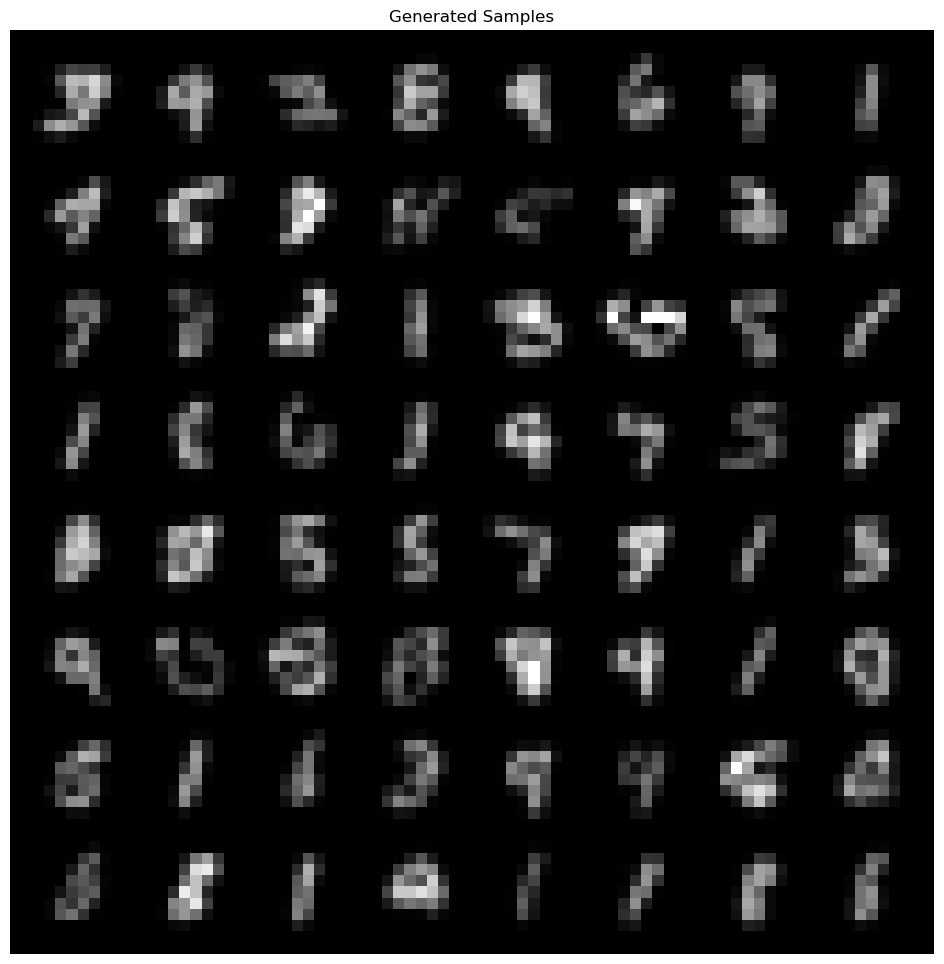

In [ ]:
# Visualization of Generated Samples
flow.load_state_dict(torch.load('best_Glow_MNIST.pth'))
flow.eval()

# compute the log likelihood of the test set
total_log_prob = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        log_prob = flow.log_prob(x, y)
        total_log_prob += log_prob.sum().item()

    avg_log_prob = total_log_prob / len(test_loader.dataset)
    print("Average Log Probability: {:.4f}".format(avg_log_prob))

with torch.no_grad():
    samples, _ = flow.sample(64)
    # clamp the samples to [0, 1]
    samples = torch.clamp(samples, 0, 1)
    print("Shape of samples:", samples.shape)


# Reshape and visualize
samples = samples.view(-1, 1, 8, 8)
grid = torchvision.utils.make_grid(samples, nrow=8, normalize=False)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title('Generated Samples')
plt.axis('off')
plt.show()

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(8),
    torchvision.transforms.ToTensor(),
    # Add Gaussian noise for dequantization
    # torchvision.transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.),
    torchvision.transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(8),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.),
    torchvision.transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load MNIST datasets
ds_MNIST_train = torchvision.datasets.MNIST(
    root='MNIST',
    train=True,
    download=True,
    transform=transform_train
)

ds_MNIST_test = torchvision.datasets.MNIST(
    root='MNIST',
    train=False,
    download=True,
    transform=transform_test
)

# DataLoader setup
batch_size = 256
train_loader = DataLoader(ds_MNIST_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_MNIST_test, batch_size=batch_size, shuffle=False)

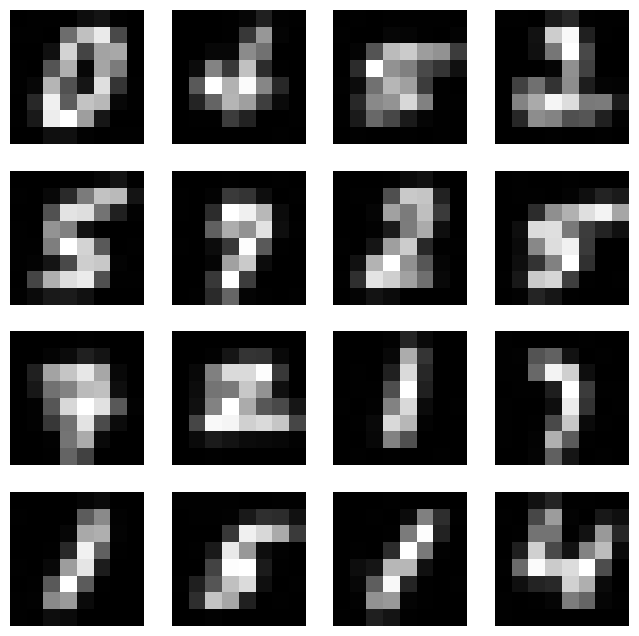

In [ ]:
# visualize the data
images, labels = next(iter(train_loader))
plt.figure(figsize=(8, 8))
for i, image in enumerate(images[:16]):
    plt.subplot(4, 4, i+1)
    plt.imshow(image.view(8, 8).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# implementation of Masked Autoregressive Flow using normflows

# number of layers
L = 5

# input image flattened, 8x8 = 64
features = 64
hidden_features = 128

flows = []
for i in range(L):
    flows += [nf.flows.affine.MaskedAffineAutoregressive(features=features, hidden_features=hidden_features, num_blocks=3)]
    flows += [nf.flows.Permute(num_channels=features)]

base_dist = nf.distributions.DiagGaussian((features,))
flow = nf.NormalizingFlow(q0=base_dist, flows=flows)

# cuda
flow = flow.to(device)

In [ ]:
learning_rate = 1e-3

# optimizer
optimizer = optim.Adam(flow.parameters(), lr=learning_rate, weight_decay=1e-5)

# scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir="runs/MAF_MNIST")

# training loop
best_val_loss = 0
num_epochs = 20
step = 0
for epoch in range(num_epochs):
    flow.train()
    total_train_loss = 0
    for x, _ in train_loader:
        x = x.view(x.size(0), -1)
        x = x.to(device)
        optimizer.zero_grad()
        loss = flow.forward_kld(x)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print("Epoch: {}, Step: {}, Loss: {:.4f}".format(epoch, step, loss.item()))
        step += 1

        total_train_loss += loss.item() * x.size(0)

    print("Epoch: {}, Loss: {:.4f}".format(epoch, loss.item()))

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    flow.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            loss = flow.forward_kld(x)
            total_val_loss += loss.item() * x.size(0)

    avg_val_loss = total_val_loss / len(test_loader.dataset)

    # Logging
    print(
        f"Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
    )
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(flow.state_dict(), "best_MAF_MNIST.pth")
        print("Model checkpoint saved.")

    # Step the scheduler
    scheduler.step()

writer.close()

Epoch: 0, Step: 0, Loss: 27.1387
Epoch: 0, Step: 100, Loss: -0.6286
Epoch: 0, Step: 200, Loss: -35.6292
Epoch: 0, Loss: -42.2643
Epoch: 0, Train Loss: 325.1643
Epoch: 0, Train Loss: 325.1643, Validation Loss: -44.0353
Model checkpoint saved.
Epoch: 1, Step: 300, Loss: -59.1449
Epoch: 1, Step: 400, Loss: -69.7785
Epoch: 1, Loss: -75.9879
Epoch: 1, Train Loss: -63.3814
Epoch: 1, Train Loss: -63.3814, Validation Loss: -74.2732
Model checkpoint saved.
Epoch: 2, Step: 500, Loss: -77.1166
Epoch: 2, Step: 600, Loss: -76.8511
Epoch: 2, Step: 700, Loss: -80.3784
Epoch: 2, Loss: -78.2388
Epoch: 2, Train Loss: -77.9628
Epoch: 2, Train Loss: -77.9628, Validation Loss: -81.3407
Model checkpoint saved.
Epoch: 3, Step: 800, Loss: -81.8422
Epoch: 3, Step: 900, Loss: -88.3388
Epoch: 3, Loss: -89.7032
Epoch: 3, Train Loss: -84.6038
Epoch: 3, Train Loss: -84.6038, Validation Loss: -86.4890
Model checkpoint saved.
Epoch: 4, Step: 1000, Loss: -89.0026
Epoch: 4, Step: 1100, Loss: -89.0993
Epoch: 4, Loss: -8

/var/folders/4f/ll38rx255klcxftt254q2vwh0000gn/T/ipykernel_91527/381953210.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load('best_MAF_MNIS

Average Log Probability: 119.1637
Shape of samples: torch.Size([64, 64])


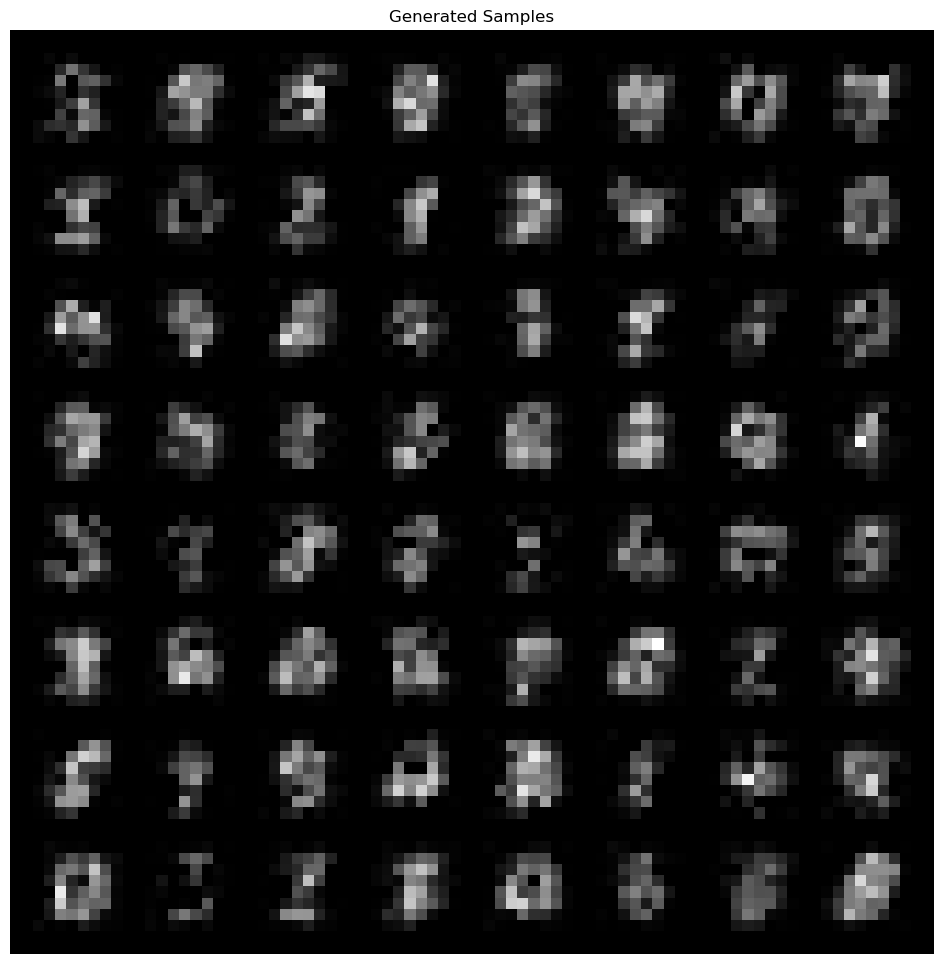

In [ ]:
# Visualization of Generated Samples
flow.load_state_dict(torch.load('best_MAF_MNIST.pth'))
flow.eval()

# compute the log likelihood of the test set
total_log_prob = 0
with torch.no_grad():
    for x, _ in test_loader:
        x = x.view(x.size(0), -1)
        x = x.to(device)
        log_prob = flow.log_prob(x)
        total_log_prob += log_prob.sum().item()

    avg_log_prob = total_log_prob / len(test_loader.dataset)
    print("Average Log Probability: {:.4f}".format(avg_log_prob))

with torch.no_grad():
    samples, _ = flow.sample(64)
    # clamp samples to [0, 1]
    samples = torch.clamp(samples, 0, 1)
    print("Shape of samples:", samples.shape)


# Reshape and visualize
samples = samples.view(-1, 1, 8, 8)
grid = torchvision.utils.make_grid(samples, nrow=8, normalize=False)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title('Generated Samples')
plt.axis('off')
plt.show()

## Question 2: WaveNet for Image Modeling

- Pick a WaveNet-typed model (e.g., WaveNet, ParallelWaveNet).
- Train the model for image modelling on MNIST.
- You can resize the MNIST images to 7 × 7 pixels to reduce computational complexity.

Some reference:
- https://medium.com/@evinpinar/wavenet-implementation-and-experiments-2d2ee57105d5
- https://github.com/kan-bayashi/ParallelWaveGAN?tab=readme-ov-file
- https://github.com/Zeta36/tensorflow-image-wavenet

For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# Pytorch lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install pytorch-lightning
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to folder for MNIST dataset
DATASET_PATH = "./MNIST/"
# Path to folder for storing the trained models in this question
CHECKPOINT_PATH = "./checkpoints/PixelCNN/"

# Set seed
pl.seed_everything(42)

# Reproducibility for GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Reproducibility for MPS
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Seed set to 42


Using device: mps


In [ ]:
from utils import _discretize
# # transformations for images, similar to the previous question, except we need to discretize the pixel values
# def _discretize(x):
#     """
#     Discretize the pixel values to 0-255.
#     Need a function to be called, for pickling to work when using num_workers in pytorch lightning dataloader.
#     """
#     return (x * 255).to(torch.long)

transform = transforms.Compose([
    transforms.Resize(11),
    transforms.ToTensor(),
    # not using dequantization since we are going to learn the distribution over the each 256 values for each pixel
    # transforms.Lambda(lambda x: x + 0.01 * torch.rand_like(x) / 256.),
    # normalize to mean 0 and std 1 using standard MNIST mean and std
    # transforms.Normalize((0.1307,), (0.3081,))

    # need to discretize instead
    # DiscretizeTransform()
    transforms.Lambda(_discretize)
])

# MNIST dataset
train_dataset = datasets.MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# dataloader
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

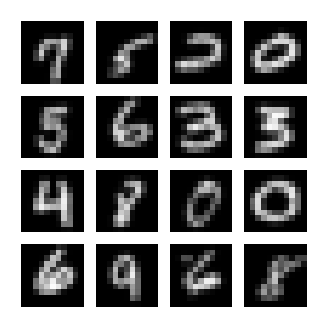

In [ ]:
# visualize images
def visualize_images(images, max_rows=4, max_cols=4):
    num_imgs = images.shape[0] if isinstance(images, torch.Tensor) else len(images)
    nrow = min(num_imgs, max_rows)
    ncol = min(num_imgs, max_cols)
    imgs = torchvision.utils.make_grid(images, nrow=ncol, pad_value=255)
    imgs = imgs.clamp(0, 255)
    plt.figure(figsize=(ncol, nrow))
    plt.imshow(imgs.cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# visualize training images
train_images = [train_set[i][0] for i in range(16)]
visualize_images(train_images)

In [ ]:
# implement masked convolution module
class MaskedConv2d(nn.Module):
    """
    Implements a convolution with mask applied to the weights.
    The mask ensures that the output can only depend on the pixels that are to the right and below the current pixel.
    This is achieved by having a random mask with all values set to 1 except for the pixels that are to the right and below the current pixel.

    Inputs:
        in_channels: int, number of input channels
        out_channels: int, number of output channels
        mask: torch.Tensor, mask with shape (kernel_size_h, kernel_size_w) with 0s where the convolution is masked
        kwargs: other arguments for the convolution
    """
    def __init__(self, in_channels, out_channels, mask, **kwargs):
        super(MaskedConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if 'dilation' not in kwargs else kwargs['dilation']
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, **kwargs)

        # buffer for mask
        # to allow the mask to be saved and loaded with the model
        # also allows the mask to be moved to the correct device
        # without buffer, need to handle device movement manually
        # also registering it as a buffer means it is not a parameter and not subject to gradient descent
        # note we don't want it to update during training
        self.register_buffer('mask', mask[None, None])

    def forward(self, x):
        # apply mask to the weights
        self.conv.weight.data *= self.mask
        return self.conv(x)



In [ ]:
# implement vertical and horizontal convolution stacks
# Although we can stack few masked convolutions on top of each other (like in PixelCNN),
# the issue is we will miss out on pixels on the upper right (blind spot), the authors of
# PixelCNN proposed a fix by splitting the convolutions into a vertical and horizontal stack.
# The vertical stack looks at the pixels above the current pixel, while the horizontal stack looks at the pixels to the left of the current pixel.
# This way, we can ensure that all pixels are considered.
class VerticalStackConvolution(MaskedConv2d):
    """
    Implements a vertical stack of masked convolutions.
    Masks out pixels below. To reduce computational complexity,
    we can reduce the kernel size in height. But for simplicity,
    we use the same kernel size for both height and width and employ masking instead.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_center=False, **kwargs):

        # create mask
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size // 2 + 1:, :] = 0

        # Mask the center row for the first convolution
        if mask_center:
            mask[kernel_size // 2, :] = 0


        super().__init__(in_channels, out_channels, mask, **kwargs)

class HorizontalStackConvolution(MaskedConv2d):
    """
    Implements a horizontal stack of masked convolutions.
    Masks out pixels on the left.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_center=False, **kwargs):

        # only have a size of 1 in height, since we only look at the pixels on the left
        mask = torch.ones(1, kernel_size)
        mask[:, kernel_size // 2 + 1:] = 0

        # Mask the center column for the first convolution
        if mask_center:
            mask[:, kernel_size // 2] = 0


        super().__init__(in_channels, out_channels, mask, **kwargs)




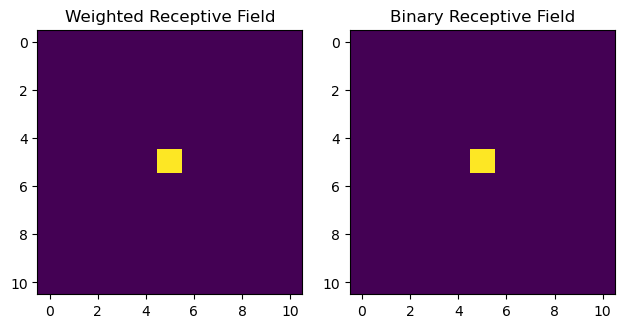

In [ ]:
# validate the masked convolutions by visualizing the receptive fields

inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad = True
def show_center_receptive_field(img, out):
    """
    Calculates gradients of input image with respect to output center pixel,
    and visualizes the overall receptive field.

    Inputs:
        img: torch.Tensor, input image with shape (1, 1, H, W)
        out: torch.Tensor, output features or loss which is used for backprop,
            should be the output of the network/computation graph
    """
    # calculate gradients
    loss = out[0, :, img.shape[2] // 2, img.shape[3] // 2].sum() # L1 loss
    loss.backward(retain_graph=True) # Retain graph since we want to stack multiple layers and show the receptive field of all of them.
    img_grads = img.grad.abs()
    img.grad.fill_(0) # Clear the gradient

    # Plot the receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img > 0)

    # mark the center of the receptive field if it does not have gradients
    show_center = (img[img.shape[0] // 2, img.shape[1] // 2] == 0)
    if show_center:
        center_pix = np.zeros(img.shape + (4,))
        center_pix[img.shape[0] // 2, img.shape[1] // 2, :] = [1, 0, 0, 1]
        ax[0].imshow(center_pix)
        ax[1].imshow(center_pix)

    ax[0].set_title('Weighted Receptive Field')
    ax[1].set_title('Binary Receptive Field')
    plt.tight_layout()
    plt.show()

show_center_receptive_field(inp_img, inp_img)

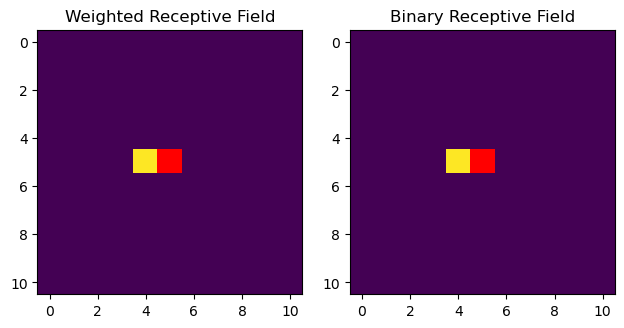

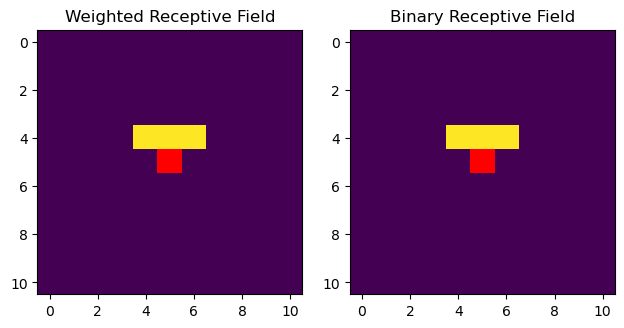

In [ ]:
# visualize horizontal and vertical convolutions

# horizontal convolution
horizontal_conv = HorizontalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=True)
horizontal_conv.conv.weight.data.fill_(1)
horizontal_conv.conv.bias.data.fill_(0)
show_center_receptive_field(inp_img, horizontal_conv(inp_img))

# vertical convolution
vertical_conv = VerticalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=True)
vertical_conv.conv.weight.data.fill_(1)
vertical_conv.conv.bias.data.fill_(0)
show_center_receptive_field(inp_img, vertical_conv(inp_img))





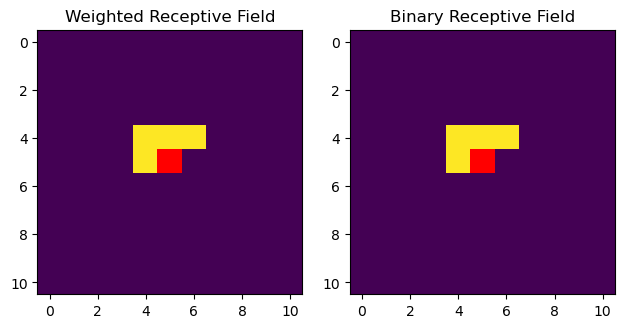

In [ ]:
# combine horizontal and vertical convolutions
show_center_receptive_field(inp_img, horizontal_conv(inp_img) + vertical_conv(inp_img))

Layer 1 Receptive Field:


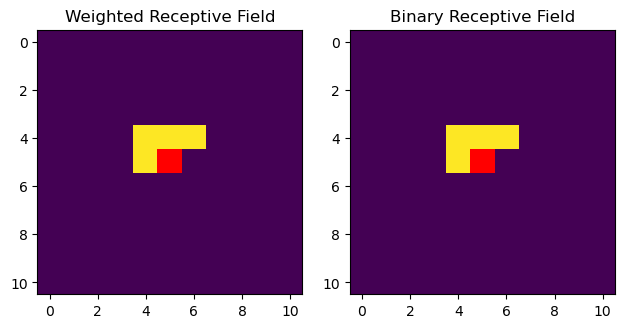

Layer 2 Receptive Field:


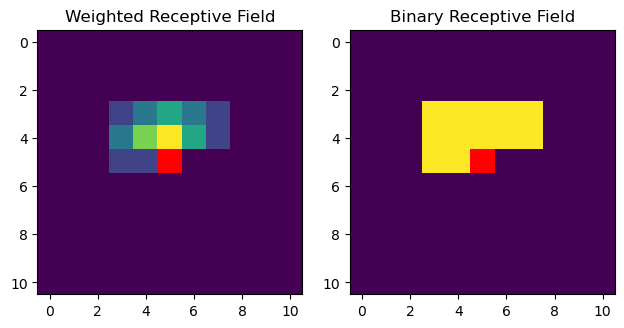

Layer 3 Receptive Field:


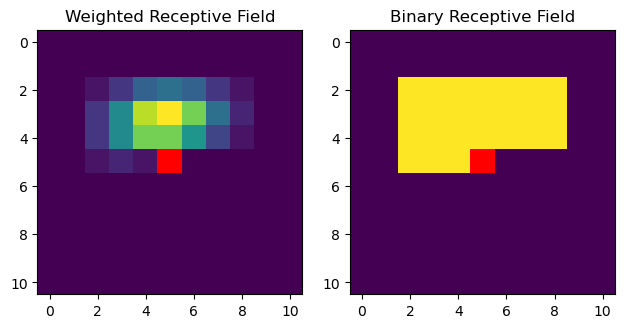

Layer 4 Receptive Field:


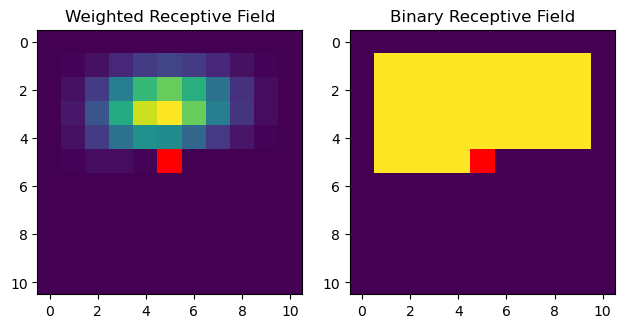

Layer 5 Receptive Field:


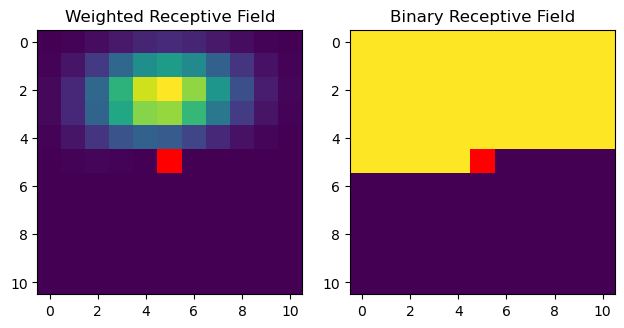

In [ ]:
# to stack multiple layers:
# horizontal convolutions can operate on the joint features of previous horizontal and vertical convolutions
#! vertical convolutions can only operate on the features of previous vertical convolutions
#! Subsequent convolutions should not be masking the center pixel, since it is already independent of its actual value

# test it on 4 layers. Reuse the convolutions for simplicity. In practice, we can use different convolutions for each layer.
# initialize the convolutions with equal weight to all input pixels, the first layer should have a mask center pixel
horizontal_conv = HorizontalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=True)
vertical_conv = VerticalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=True)
horizontal_conv.conv.weight.data.fill_(1)
vertical_conv.conv.weight.data.fill_(1)
horizontal_conv.conv.bias.data.fill_(0)
vertical_conv.conv.bias.data.fill_(0)

inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad = True

vert_out = vertical_conv(inp_img)
horiz_out = horizontal_conv(inp_img)
horiz_out = horiz_out + vert_out
print("Layer 1 Receptive Field:")
show_center_receptive_field(inp_img, horiz_out)

# now the convolutions should not mask the center pixel
horizontal_conv = HorizontalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=False)
vertical_conv = VerticalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=False)
horizontal_conv.conv.weight.data.fill_(1)
vertical_conv.conv.weight.data.fill_(1)
horizontal_conv.conv.bias.data.fill_(0)
vertical_conv.conv.bias.data.fill_(0)

# stack the convolutions
for layer in range(4):
    vert_out = vertical_conv(vert_out)
    horiz_out = horizontal_conv(horiz_out) + vert_out
    print(f"Layer {layer + 2} Receptive Field:")
    show_center_receptive_field(inp_img, horiz_out)



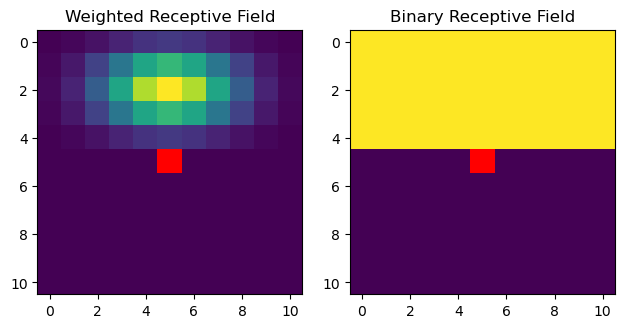

In [ ]:
# check receptive field for the vertical stack after 4 layers
show_center_receptive_field(inp_img, vert_out)

del horizontal_conv, vertical_conv, horiz_out, vert_out, inp_img

In [ ]:
# gated masked convolutions
class GatedMaskedConv2d(nn.Module):
    """
    Implements a gated masked convolution.
    """
    def __init__(self, in_channels, **kwargs):
        super().__init__()

        self.conv_vert = VerticalStackConvolution(in_channels=in_channels, out_channels=2*in_channels, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(in_channels=in_channels, out_channels=2*in_channels, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0)


    def forward(self, vert_stack, horiz_stack):
        # Vertical stack
        vert_stack_feat = self.conv_vert(vert_stack)
        vert_val, vert_gate = vert_stack_feat.chunk(2, dim=1)
        vert_stack_out = torch.tanh(vert_val) * torch.sigmoid(vert_gate)

        # Horizontal stack
        horiz_stack_feat = self.conv_horiz(horiz_stack)
        horiz_stack_feat = horiz_stack_feat + self.conv_vert_to_horiz(vert_stack_feat)
        horiz_val, horiz_gate = horiz_stack_feat.chunk(2, dim=1)
        horiz_stack_feat = torch.tanh(horiz_val) * torch.sigmoid(horiz_gate)
        horiz_stack_out = self.conv_horiz_1x1(horiz_stack_feat)
        horiz_stack_out = horiz_stack_out + horiz_stack

        return vert_stack_out, horiz_stack_out

In [ ]:
class PixelCNN(pl.LightningModule):

    def __init__(self, in_channels, hidden_channels, num_layers):
        super(PixelCNN, self).__init__()
        self.save_hyperparameters()

        # initial convolutions, skip the center pixel
        self.conv_init_vert = VerticalStackConvolution(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, mask_center=True)
        self.conv_init_horiz = HorizontalStackConvolution(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, mask_center=True)

        # convolution block of PixelCNN, use dilation to increase receptive field
        self.conv_block = nn.ModuleList([
            GatedMaskedConv2d(hidden_channels),
            GatedMaskedConv2d(hidden_channels, dilation=1),
            GatedMaskedConv2d(hidden_channels),
            GatedMaskedConv2d(hidden_channels, dilation=2),
            GatedMaskedConv2d(hidden_channels),
            GatedMaskedConv2d(hidden_channels, dilation=1),
            GatedMaskedConv2d(hidden_channels),
        ])

        # output convolution, convolution with 1x1 kernel, output is logits for each of the 256 values for each pixel
        self.conv_out = nn.Conv2d(hidden_channels, in_channels * 256, kernel_size=1, padding=0)

    def forward(self, x):
        """
        Forward image through the network, return logits for each of the 256 values for each pixel
        Input is a tensor of shape (B, C, H, W)
        """
        # Scale input from 0-255 to -1-1
        x = x.float() / 255. * 2 - 1

        # initial convolutions
        vert_stack = self.conv_init_vert(x)
        horiz_stack = self.conv_init_horiz(x)

        # convolution block
        for conv in self.conv_block:
            vert_stack, horiz_stack = conv(vert_stack, horiz_stack)

        # ELU activation before output convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(horiz_stack))

        # Output [B, Class, C, H, W]
        return out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])

    def compute_likelihood(self, x):
        """
        Compute the likelihood of the model
        Input is a tensor of shape (B, C, H, W)
        """
        out = self.forward(x)
        nll = F.cross_entropy(out, x, reduction='none')
        bpd = nll.mean(dim=(1,2,3)) / np.log2(np.exp(1)) # bits per dimension
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sample from the model
        Inputs:
            img_shape: tuple, shape of the image to sample (B, C, H, W)
            img: torch.Tensor, image to continue sampling, if None, sample from -1s. Pixels to be filled should be -1s.
        """
        if img is None:
            img = torch.ones(img_shape) * -1

        # Generation
        for h in range(img.shape[2]):
            for w in range(img.shape[3]):
                for c in range(img.shape[1]):
                    if (img[:, c, h, w] != -1).all().item():
                        continue

                    # Only consider the pixels to the right and below the current pixel
                    pred = self.forward(img[:, :, :h+1, :])
                    probs = F.softmax(pred[:, :, c, h, w], dim=-1) # compute the probabilities of the 256 values for the current pixel
                    img[:, c, h, w] = torch.multinomial(probs, num_samples=1).squeeze(-1) # sample one value from the 256 values
        return img

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    # batch_idx is provided by PyTorch Lightning to track which batch is being processed in the epoch
    def training_step(self, batch, batch_idx):
        loss = self.compute_likelihood(batch[0]) # batch[0] is the image, batch[1] is the label
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.compute_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        loss = self.compute_likelihood(batch[0])
        self.log('test_bpd', loss)

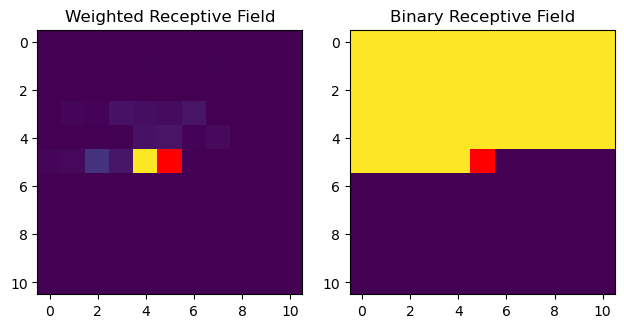

In [ ]:
test_model = PixelCNN(in_channels=1, hidden_channels=64, num_layers=4)
inp = torch.zeros(1,1,11,11)
inp.requires_grad_()
out = test_model(inp)
show_center_receptive_field(inp, out.squeeze(dim=2))
del inp, out, test_model

In [ ]:
import os
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


# Create generation callback to monitor training progress
class GenerateCallback(pl.Callback):
    def __init__(self, every_n_epochs=1):
        """
        Inputs:
            every_n_epochs - Only save those images every N epochs (default: 1)
        """
        super().__init__()
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, trainer, pl_module):
        """
        This function is called after every epoch.
        """
        if (trainer.current_epoch+1) % self.every_n_epochs == 0:
            # Generate images
            with torch.no_grad():
                pl_module.eval()
                imgs_shape = (4, 1, 11, 11)  # Generate 4 images
                imgs = pl_module.sample(imgs_shape)
                pl_module.train()

            # Plot and save images
            imgs = imgs.cpu()
            imgs_grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
            trainer.logger.experiment.add_image("generated_images", imgs_grid, global_step=trainer.global_step)

# # Set up model and training
# CHECKPOINT_PATH = "saved_models/pixelcnn.ckpt"
# os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)

def train_pixelcnn(train_loader, val_loader, **kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        # default_root_dir=os.path.dirname(CHECKPOINT_PATH),
        accelerator="auto",
        devices=1,
        max_epochs=100,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
            GenerateCallback(every_n_epochs=5),
            # Early stopping
            EarlyStopping(monitor="val_bpd", mode="min", patience=5, verbose=True),
            LearningRateMonitor(logging_interval='epoch')
        ],
        enable_progress_bar=True,
        logger=TensorBoardLogger("lightning_logs", name="pixelcnn")
    )

    # Check if pretrained model exists, if yes load it
    if os.path.isfile(CHECKPOINT_PATH):
        print("Found pretrained model, loading...")
        model = PixelCNN.load_from_checkpoint(CHECKPOINT_PATH)
    else:
        print("Training model from scratch...")
        model = PixelCNN(in_channels=1, hidden_channels=64, num_layers=7)
        trainer.fit(model, train_loader, val_loader)
        # Load best model after training
        model = PixelCNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.validate(model, val_loader, verbose=True)
    test_result = trainer.test(model, test_loader, verbose=True)

    return model, val_result, test_result

if __name__ == "__main__":

    transform = transforms.Compose([
        transforms.Resize(11),
        transforms.ToTensor(),
        # not using dequantization since we are going to learn the distribution over the each 256 values for each pixel
        # transforms.Lambda(lambda x: x + 0.01 * torch.rand_like(x) / 256.),
        # normalize to mean 0 and std 1 using standard MNIST mean and std
        # transforms.Normalize((0.1307,), (0.3081,))

        # need to discretize instead
        # DiscretizeTransform()
        transforms.Lambda(_discretize)
    ])

    train_set = torchvision.datasets.MNIST(root='./MNIST', train=True, transform=transform, download=True)
    val_set = torchvision.datasets.MNIST(root='./MNIST', train=False, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./MNIST', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

    # Train model with default parameters
    model, val_result, test_result = train_pixelcnn(train_loader, val_loader)

    print(f"Validation BPD: {val_result[0]['val_bpd']:.4f}")
    print(f"Test BPD: {test_result[0]['test_bpd']:.4f}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                       | Params
---------------------------------------------------------------
0 | conv_init_vert  | VerticalStackConvolution   | 640   
1 | conv_init_horiz | HorizontalStackConvolution | 256   
2 | conv_block      | ModuleList                 | 834 K 
3 | conv_out        | Conv2d                     | 16.6 K
---------------------------------------------------------------
852 K     Trainable params
0         Non-trainable params
852 K     Total params
3.409     Total estimated model params size (MB)


Training model from scratch...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/diffmap/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/homebrew/Caskroom/miniforge/base/envs/diffmap/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved. New best score: 1.291


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.078 >= min_delta = 0.0. New best score: 1.213


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.036 >= min_delta = 0.0. New best score: 1.177


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.009 >= min_delta = 0.0. New best score: 1.168


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.024 >= min_delta = 0.0. New best score: 1.144


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.015 >= min_delta = 0.0. New best score: 1.130


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.013 >= min_delta = 0.0. New best score: 1.117


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.012 >= min_delta = 0.0. New best score: 1.105


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.007 >= min_delta = 0.0. New best score: 1.097


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.005 >= min_delta = 0.0. New best score: 1.092


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.002 >= min_delta = 0.0. New best score: 1.090


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.001 >= min_delta = 0.0. New best score: 1.089


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.007 >= min_delta = 0.0. New best score: 1.082


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.003 >= min_delta = 0.0. New best score: 1.079


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.003 >= min_delta = 0.0. New best score: 1.076


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.003 >= min_delta = 0.0. New best score: 1.074


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.004 >= min_delta = 0.0. New best score: 1.070


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.001 >= min_delta = 0.0. New best score: 1.069


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.003 >= min_delta = 0.0. New best score: 1.067


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.000 >= min_delta = 0.0. New best score: 1.067


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.003 >= min_delta = 0.0. New best score: 1.064


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.005 >= min_delta = 0.0. New best score: 1.059


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.000 >= min_delta = 0.0. New best score: 1.058


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.001 >= min_delta = 0.0. New best score: 1.057


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.001 >= min_delta = 0.0. New best score: 1.056


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.001 >= min_delta = 0.0. New best score: 1.055


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.001 >= min_delta = 0.0. New best score: 1.055


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.000 >= min_delta = 0.0. New best score: 1.055


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.000 >= min_delta = 0.0. New best score: 1.054


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.002 >= min_delta = 0.0. New best score: 1.053


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.000 >= min_delta = 0.0. New best score: 1.053


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_bpd improved by 0.002 >= min_delta = 0.0. New best score: 1.051


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_bpd did not improve in the last 5 records. Best score: 1.051. Signaling Trainer to stop.
/opt/homebrew/Caskroom/miniforge/base/envs/diffmap/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded f

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_bpd          │    1.0508787631988525     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/Caskroom/miniforge/base/envs/diffmap/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_bpd          │    1.0508787631988525     │
└───────────────────────────┴───────────────────────────┘

Validation BPD: 1.0509
Test BPD: 1.0509


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 16, 1, 8] to have 1 channels, but got 16 channels instead

Loading checkpoint from: lightning_logs/pixelcnn/version_13/checkpoints/epoch=36-step=17353.ckpt
Runtime Error: Mismatched Tensor types in NNPack convolutionOutput

Trying alternative approach...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


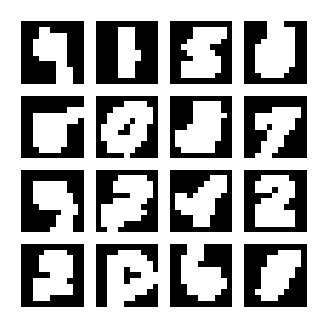

In [ ]:
import glob

def load_latest_model():
    # Find all checkpoint files in the Lightning logs directory
    checkpoint_files = glob.glob("lightning_logs/pixelcnn/version_*/checkpoints/*.ckpt")

    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found")

    # Get the most recent checkpoint file based on modification time
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    print(f"Loading checkpoint from: {latest_checkpoint}")

    # Load the model
    model = PixelCNN.load_from_checkpoint(latest_checkpoint)

    # Move model to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available()
                         else "mps" if torch.backends.mps.is_available()
                         else "cpu")
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    return model, device

# Usage
try:
    model, device = load_latest_model()

    # Generate samples
    with torch.no_grad():
        # Create sample tensor on the same device as model
        img_shape = (16, 1, 11, 11)
        samples = model.sample(img_shape=img_shape)

        # Move samples to CPU for visualization
        samples = samples.cpu()

    # Display samples
    samples_grid = torchvision.utils.make_grid(images, nrow=4, pad_value=255)
    samples_grid = samples_grid.clamp(0, 255)
    plt.figure(figsize=(8,8))
    plt.imshow(samples_grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
except RuntimeError as e:
    print(f"Runtime Error: {e}")
    print("\nTrying alternative approach...")

    # If the above fails, try forcing CPU execution
    model = model.cpu()
    with torch.no_grad():
        samples = model.sample(img_shape=(16, 1, 11, 11))
        samples = samples.cpu()

    visualize_images(samples)

## Question 3: Energy-based Models

- make a simple energy-based model with E(x,\theta) = f_{\theta}(x). Here, f_{\theta}() is a simple 2-layer convolutional network (CNN). You should design this CNN yourself, which include (at least) 2 convolutional layers.
- train and use Gibbs sampling and Langevin Dynamics method on USPS.

For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

If you are interested in the above, start thinking about presentation topics and talk to Vahid. <br>
If you are interested in something later on in the class, skim through the slides, also start thinking about presentation topics and talk to Vahid.

In [5]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install pytorch-lightning
    import pytorch_lightning as pl

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import matplotlib.pyplot as plt

method = 'gibbs'
CHECKPOINT_PATH = f"saved_models/energy_model_{method}.ckpt"
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [6]:
class Sampler:
    def __init__(self, model, img_shape, sample_size, max_len=8192, method='langevin'):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
            binary - If True, use binary pixels (0/1). If False, use continuous values
            method - Sampling method to use. 'langevin' or 'gibbs'
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.method = method
        # Initialize buffer with random samples
        self.examples = [(torch.rand((1,)+img_shape) > 0.5).float() * 2 - 1 if self.method == 'gibbs'
                        else (torch.rand((1,)+img_shape)*2-1)
                        for _ in range(self.sample_size)]


    def sample_new_exmps(self, steps=60, step_size=10, method='langevin'):
        """
        Get new batch of samples using either Langevin dynamics or Gibbs sampling
        """
        # Choose 95% of batch from buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        if self.method == 'gibbs':
            rand_imgs = (torch.rand((n_new,) + self.img_shape) > 0.5).float() * 2 - 1
        else:
            rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1

        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # # Perform sampling
        # print("Sampling:")
        # print("Shape of inp_imgs:", inp_imgs.shape)
        inp_imgs = self.generate_samples(self.model, inp_imgs, steps, step_size, method=method)

        # Update buffer
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False, method='langevin'):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()

        if method == 'langevin':
            print("Langevin sampling:")
            for p in model.parameters():
                p.requires_grad = False
            inp_imgs.requires_grad = True

            # Enable gradient calculation if not already the case
            had_gradients_enabled = torch.is_grad_enabled()
            torch.set_grad_enabled(True)

            # We use a buffer tensor in which we generate noise each loop iteration.
            # More efficient than creating a new tensor every iteration.
            noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

            # List for storing generations at each step (for later analysis)
            imgs_per_step = []

            # Loop over K (steps)
            for _ in range(steps):
                # Part 1: Add noise to the input.
                noise.normal_(0, 0.005)
                inp_imgs.data.add_(noise.data)
                inp_imgs.data.clamp_(min=-1.0, max=1.0)

                # Part 2: calculate gradients for the current input.
                out_imgs = -model(inp_imgs)
                out_imgs.sum().backward()
                inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

                # Apply gradients to our current samples
                inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
                inp_imgs.grad.detach_()
                inp_imgs.grad.zero_()
                inp_imgs.data.clamp_(min=-1.0, max=1.0)

                if return_img_per_step:
                    imgs_per_step.append(inp_imgs.clone().detach())

            # Reactivate gradients for parameters for training
            for p in model.parameters():
                p.requires_grad = True
            model.train(is_training)

            # Reset gradient calculation to setting before this function
            torch.set_grad_enabled(had_gradients_enabled)

            if return_img_per_step:
                return torch.stack(imgs_per_step, dim=0)
            else:
                return inp_imgs

        elif method == 'gibbs':
            for _ in range(steps):
                # flip small number of pixels in the image (-1 to 1 or vice versa)
                mask = torch.rand_like(inp_imgs) < 0.01
                inp_imgs = inp_imgs.clone()
                inp_imgs[mask] = -inp_imgs[mask]  # flip the selected pixels

                # Perform Gibbs sampling step
                inp_imgs = Sampler.gibbs_step(model, inp_imgs)
            return inp_imgs


    @staticmethod 
    def gibbs_step(model, x):
        """
        Perform one full Gibbs sampling step, updating every pixel in random order.
        Uses masking for efficient energy computation.
        """
        batch_size = x.shape[0]  # [B, 1, H, W]
        h, w = x.shape[2:]
        n_pixels = h * w

        # Randomize the order in which pixels are updated
        pixel_order = torch.randperm(n_pixels)

        for idx in pixel_order:  # Loop over every pixel
            i, j = idx // w, idx % w

            # Compute energies for -1 and 1 states
            x[:, :, i, j] = -1.0
            energy_neg = -model(x)  # Add negative sign since model is -E
            x[:, :, i, j] = 1.0
            energy_pos = -model(x)  # Add negative sign since model is -E

            # Compute probabilities
            logits = torch.stack([energy_pos, energy_neg], dim=1)  # [B, 2]
            probs = F.softmax(logits, dim=1)  # [B, 2]

            # Sample new pixel values 
            choices = torch.multinomial(probs, 1)  # [B, 1]
            x[:, :, i, j] = choices.float() * 2 - 1  # Convert 0/1 to -1/1

        return x


In [7]:
class DeepEnergyModel(pl.LightningModule):

    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, method='langevin', steps=60, step_size=10, **CNN_args):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size, method=method)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):

        real_imgs, _ = batch

        if self.hparams.method == 'langevin':
            # add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
            small_noise = torch.randn_like(real_imgs) * 0.005
            real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        elif self.hparams.method == 'gibbs':
            # flip small number of pixels in the image
            mask = torch.rand_like(real_imgs) < 0.01
            real_imgs = real_imgs.clone()
            real_imgs[mask] = -real_imgs[mask]

        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=self.hparams.steps, step_size=self.hparams.step_size, method=self.hparams.method)

        # print("Training step:")
        # print("Shape of real_imgs:", real_imgs.shape)
        # print("Shape of fake_imgs:", fake_imgs.shape)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        # print("Validation step:")
        # print("Shape of real_imgs:", real_imgs.shape)
        # print("Shape of fake_imgs:", fake_imgs.shape)

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

In [8]:
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size         # Number of images to generate
        self.vis_steps = vis_steps           # Number of steps within generation to visualize
        self.num_steps = num_steps           # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1))
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)

    def generate_imgs(self, pl_module):
        pl_module.eval()
        if pl_module.hparams.method == 'langevin':
            start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            start_imgs = start_imgs * 2 - 1
            torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary

        elif pl_module.hparams.method == 'gibbs':
            start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            start_imgs = (start_imgs > 0.5).float() * 2 - 1  # Convert to {-1, 1}

        imgs_per_step = Sampler.generate_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True, method=pl_module.hparams.method)
        torch.set_grad_enabled(False)
        pl_module.train()
        return imgs_per_step

In [9]:
class SamplerCallback(pl.Callback):

    def __init__(self, num_imgs=32, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs             # Number of images to plot
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)

In [10]:
class OutlierCallback(pl.Callback):

    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size

    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            if pl_module.hparams.method == 'langevin':
                rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
                rand_imgs = rand_imgs * 2 - 1.0
            elif pl_module.hparams.method == 'gibbs':
                rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
                rand_imgs = (rand_imgs > 0.5).float() * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()

        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

In [11]:
def train_model(method='langeivn', **kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "USPS"),
                         accelerator="gpu" if str(device).startswith("cuda") or str(device).startswith("mps") else "cpu",
                         devices=1,
                         max_epochs=60,
                         gradient_clip_val=0.1,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor='val_contrastive_divergence'),
                                    GenerateCallback(every_n_epochs=5),
                                    SamplerCallback(every_n_epochs=5),
                                    OutlierCallback(),
                                    LearningRateMonitor("epoch")
                                   ])
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "USPS.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(method=method, **kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

In [1]:
# reload utils and _binarize
# from utils import _binarize
import os

def _binarize(x):
    """
    Binarize the pixel values to -1 and 1.
    """
    return torch.where(x > 0.5, torch.tensor(1.0), torch.tensor(-1.0))


# Load USPS dataset and create dataloaders
transform = transforms.Compose([
    # transforms.Resize(11),
    transforms.ToTensor(),
    transforms.Lambda(_binarize)
])

train_dataset = datasets.USPS(root='USPS/', train=True, download=True, transform=transform)
test_dataset = datasets.USPS(root='USPS/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=0)

# check the shape of the data
x, _ = next(iter(train_loader))
# print(f"Training data shape: {x.shape}")


model = train_model(img_shape=(1,16,16),
                    batch_size=train_loader.batch_size,
                    lr=1e-4,
                    beta1=0.0,
                    method=method,
                    steps=5,
                    step_size=10
                    )

NameError: name 'transforms' is not defined